In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import cv2 as cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys,os, itertools
%matplotlib inline

In [5]:
img = cv2.imread('tms-data/train/septoria-leafspot/BK1.JPG',cv2.IMREAD_UNCHANGED)

In [6]:
if img is None:
    sys.exit("Could not read the image.")

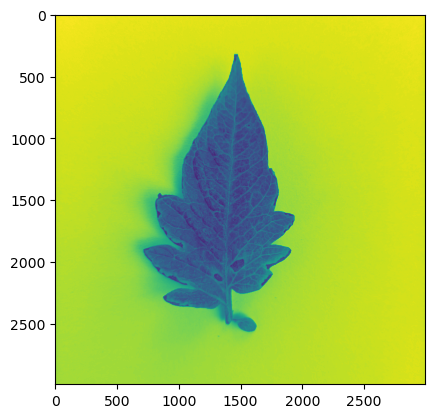

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

### Preprocessing Data to .csv files

In [39]:
BASE_DIR = 'tms-data/train/'
bercak = BASE_DIR+'septoria-leafspot/'
penggorok = BASE_DIR+'liriomyza-leafspot/'
sehat = BASE_DIR+'healthy-leaves/'

files_in_bercak = sorted(os.listdir(bercak))
files_in_penggorok = sorted(os.listdir(penggorok))
files_in_sehat = sorted(os.listdir(sehat))

df = pd.DataFrame()

path = [bercak+ str(x) for x in files_in_bercak]+[penggorok+ str(x) for x in files_in_penggorok]+[sehat+ str(x) for x in files_in_sehat]
label = [ label.split('/')[2] for label in path ]

df['path'] = path
df['label'] = label

df.to_csv('data/data.csv', columns=['path','label'],index=False)

In [9]:
def read_csv(path):
    return pd.read_csv(path)

In [10]:
data = read_csv('data/data.csv')

In [12]:
data['path']

0                tms-data/train/septoria-leafspot/BK1.jpg
1               tms-data/train/septoria-leafspot/BK10.jpg
2               tms-data/train/septoria-leafspot/BK11.jpg
3               tms-data/train/septoria-leafspot/BK12.jpg
4               tms-data/train/septoria-leafspot/BK13.jpg
                              ...                        
1528    tms-data/train/healthy-leaves/IMG_20220918_102...
1529    tms-data/train/healthy-leaves/IMG_20220918_102...
1530    tms-data/train/healthy-leaves/IMG_20220918_102...
1531    tms-data/train/healthy-leaves/IMG_20220918_102...
1532    tms-data/train/healthy-leaves/IMG_20220918_102...
Name: path, Length: 1533, dtype: object

In [13]:
def scaleImage(path):
    
    img = cv2.imread(path)
    img = cv2.medianBlur(img,5)
    
    scale_percent = 10 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim,cv2.COLOR_BGR2RGB)
    
    print('Resized Dimensions : ',resized.shape)

    plt.imshow(resized)
    plt.show()
    
    print('Grayscale Image: ')
    
    img_gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    plt.imshow(img_gray)
    plt.show()
    
    print('RGB to HSV: ')
    img_rgb_hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    plt.imshow(img_rgb_hsv)
    plt.show()
    
    
#     print('Yellow color: ')
#     yellow_lower = np.array([20, 100, 100])
#     yellow_upper = np.array([30, 255, 255])
    
#     mask_yellow = cv2.inRange(img_rgb_hsv, yellow_lower, yellow_upper)

#     yellow_output = cv2.bitwise_and(img, img, mask=mask_yellow)

#     yellow_ratio =(cv2.countNonZero(mask_yellow))/(img.size/3)
    
#     plt.imshow(mask_yellow)
#     plt.show()
    
    print('Treshold image: ')
    ret, img_treshold = cv2.threshold(resized,127,255, cv2.THRESH_BINARY_INV)
#     fig = plt.figure(figsize=(7,9),frameon=False)

#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)
#     rgbImg = cv2.cvtColor(img_treshold, cv2.COLOR_BGR2RGB)
#     cv2.imwrite(os.path.join('train/busuk/' , 'waka.jpg'), rgbImg)
#     cv2.waitKey(0)
    plt.imshow(img_treshold)
    
#     plt.savefig('testss.png')
    plt.show()

Resized Dimensions :  (299, 299, 3)


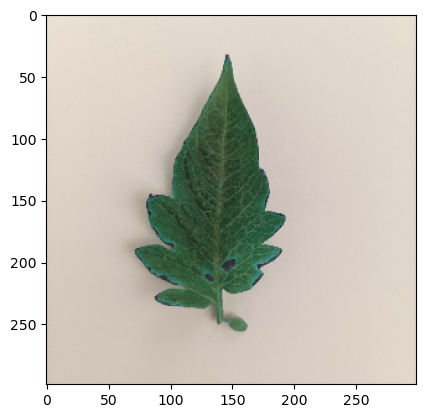

Grayscale Image: 


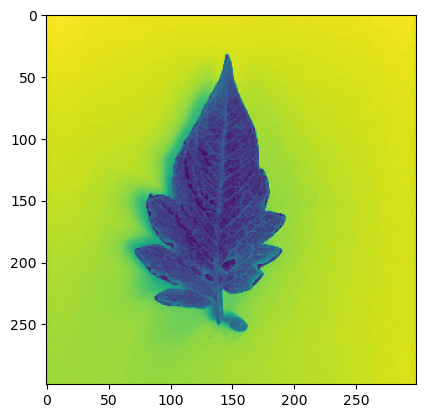

RGB to HSV: 


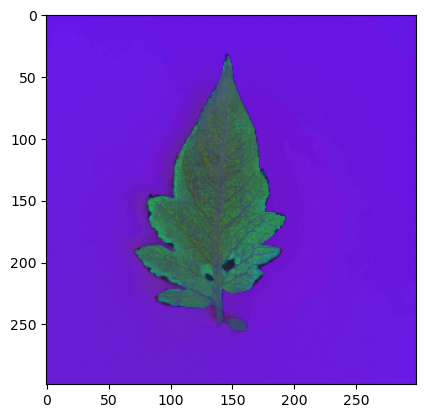

Treshold image: 


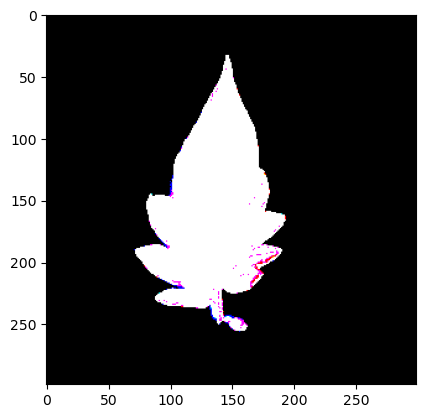

In [14]:
scaleImage(data['path'][0])

In [15]:
def threshold(img):
    ret, img_treshold = cv2.threshold(img,127,255, cv2.THRESH_BINARY_INV)
    return img_treshold

In [16]:
def read_img(path):
    img = cv2.imread(path)
    img = cv2.medianBlur(img,5)
    return img

In [17]:
def scale_img(img,scale=10):
    scale_percent = scale # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
#     resized = cv2.resize(img, (302,403),cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (width,height),cv2.COLOR_BGR2RGB)
    return resized

In [18]:
def grayscale(img):
    img_gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

In [19]:
def rgb_hsv(img):
    img_rgb_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img_rgb_hsv

### Create new train and validation data

In [21]:
newPathCSV = []
newLabelCSV = []
newDf = pd.DataFrame()

# img = read_img(data['path'][0])
# img = scale_img(img)
# img = threshold(img)
# img.size
for i in range(len(data)):
    
    FOLDER_TRAIN = 'data_after_preprocessing/train/'
    label = data['path'][i].split('/')[2]
    fileName = data['path'][i].split('/')[3]
    newPath = FOLDER_TRAIN+label+'/'
    
    img = read_img(data['path'][i])
    img = scale_img(img)
    img = threshold(img)
#     plt.imshow(img)
    rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(os.path.join(newPath , fileName), rgbImg)
    print(cv2.imwrite(os.path.join(newPath , fileName), rgbImg))
#     cv2.waitKey(0)
#     plt.savefig(newPath)
    print(os.path.join(newPath , fileName))
    newPathCSV.append(newPath+fileName)
    newLabelCSV.append(label)
    

newDf['path'] = newPathCSV
newDf['label'] = newLabelCSV

newDf.to_csv('data/data_after_prepro.csv', columns=['path','label'],index=False)  
newDf

True
data_after_preprocessing/train/septoria-leafspot/BK1.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK10.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK11.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK12.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK13.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK14.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK15.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK16.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK17.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK18.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK19.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK2.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK20.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK21.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK22.jpg
True
data_after_preprocessing/train/septoria-leafspot/BK2

True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_070831.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_070837.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_070840.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071157.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071200.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071224.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071233.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071303.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071337.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071406.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071418.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220911_071422.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_202209

True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065015.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065025.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065030.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065042.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065051.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065058.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065105.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065120.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065123.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065137.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065144.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_065242.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_202209

True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071801.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071803.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071810.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071813.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071825.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071828.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071831.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071900.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071902.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071906.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071920.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_071923.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_202209

True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102704.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102714.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102719.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102732.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102736.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102752.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102800.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102821.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102827.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102836.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102843.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_20220918_102850.jpg
True
data_after_preprocessing/train/septoria-leafspot/IMG_202209

True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_180425.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_180809.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181007.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181028.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181101.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181206.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181209.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181257.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181302.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181314.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181322.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220910_181425.jpg
True
data_after_preprocessing/train/liriomyza-leafsp

True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094647.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094654.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094700.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094732.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094734.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094759.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094803.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094916.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094921.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094938.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094941.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220911_094946.jpg
True
data_after_preprocessing/train/liriomyza-leafsp

True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110339.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110342.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110344.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110357.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110400.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110407.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110409.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110412.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110418.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110421.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110425.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_110433.jpg
True
data_after_preprocessing/train/liriomyza-leafsp

True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111610.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111614.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111621.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111625.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111628.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111632.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111638.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111640.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111644.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111654.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111659.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_111705.jpg
True
data_after_preprocessing/train/liriomyza-leafsp

True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112345.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112348.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112358.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112410.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112414.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112420.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112424.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112433.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112437.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112447.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112449.jpg
True
data_after_preprocessing/train/liriomyza-leafspot/IMG_20220918_112451.jpg
True
data_after_preprocessing/train/liriomyza-leafsp

True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_070131.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_070137.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_070238.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_070241.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_070918.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_070921.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_070937.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_070940.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_071007.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_071011.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_071128.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_071138.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_071815.jpg
True
data_after_preproces

True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_100226.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_100404.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220911_100407.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070003.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070003_1.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070028.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070052.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070119.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070124.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070125.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070130.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070132.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_070202.jpg
True
data_after_preproc

True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_072954.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_072957.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073006.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073008.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073017.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073043.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073101.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073133.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073142.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073148.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073204.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073209.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_073232.jpg
True
data_after_preproces

True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_095825.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_095829.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_095850.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_095853.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_095930.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_095934.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_095948.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_095954.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_100009.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_100015.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_100028.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_100034.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_100040.jpg
True
data_after_preproces

True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_101951.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_101952.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_101955.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102008.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102009.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102020.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102034.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102038.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102051.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102059.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102141.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102148.jpg
True
data_after_preprocessing/train/healthy-leaves/IMG_20220918_102149.jpg
True
data_after_preproces

,path,label
0,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
1,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
2,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
3,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
4,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
...,...,...
1528,data_after_preprocessing/train/healthy-leaves/...,healthy-leaves
1529,data_after_preprocessing/train/healthy-leaves/...,healthy-leaves
1530,data_after_preprocessing/train/healthy-leaves/...,healthy-leaves
1531,data_after_preprocessing/train/healthy-leaves/...,healthy-leaves


In [22]:
newDf[["path", "label"]].groupby("label").count()
newDf

,path,label
0,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
1,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
2,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
3,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
4,data_after_preprocessing/train/septoria-leafsp...,septoria-leafspot
...,...,...
1528,data_after_preprocessing/train/healthy-leaves/...,healthy-leaves
1529,data_after_preprocessing/train/healthy-leaves/...,healthy-leaves
1530,data_after_preprocessing/train/healthy-leaves/...,healthy-leaves
1531,data_after_preprocessing/train/healthy-leaves/...,healthy-leaves


### Copying For Validation Data

In [25]:
import shutil
import random

def get_file_list(input_dir):
    return [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]

def get_random_files(file_list, N):
    return random.sample(file_list, N)

def copy_files(random_files, input_dir, output_dir):
    for file in random_files:
        shutil.copy(os.path.join(input_dir, file), output_dir)

def main_copy(input_dir, output_dir, N):
    file_list = get_file_list(input_dir)
    random_files = get_random_files(file_list, N)
    copy_files(random_files, input_dir, output_dir)
    
main_copy('data_after_preprocessing/train/liriomyza-leafspot', 'data_after_preprocessing/validation/liriomyza-leafspot', 100)

In [28]:
def modelCNN():

    model = Sequential()
    #1-Convolution
    model.add(Conv2D(32, (3,3), strides=(1,1), input_shape = (300,300,3), activation = 'relu'))
    #2-Pooling
    model.add(MaxPooling2D(pool_size = (2,2)))
    #add second conv
    model.add(Conv2D(32, (3,3), strides=(1,1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #add third conv
    model.add(Conv2D(32, (3,3), strides=(1,1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #add third conv
    model.add(Conv2D(64, (3,3), strides=(1,1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #add third conv
    model.add(Conv2D(64, (3,3), strides=(1,1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #3-Flattening
    model.add(Flatten())
    #4-Full Connection
    model.add(Dense(activation = 'relu', units = 900))
    model.add(Dense(activation = 'relu', units = 90))
    model.add(Dense(activation = 'softmax', units = 3))


    #Compiling CNN
    rmsprop = optimizers.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = rmsprop, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()

    return model

In [29]:
model = modelCNN()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 35, 35, 32)      

In [30]:
def save_graph(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('static/assets/accuracy.png')
    plt.close()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('static/assets/loss.png')
    plt.close()
    
    return "Save Successful"

In [31]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)
# test_datagen = ImageDataGenerator(rescale=1. / 255)

# this is a generator that will read pictures found in subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data_after_preprocessing/train',  # this is the target directory
        target_size=(300,300),  # all images will be resized to 300x300
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
print('data train',train_generator)
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data_after_preprocessing/validation',
        target_size=(300,300),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 1533 images belonging to 3 classes.
data train <keras.preprocessing.image.DirectoryIterator object at 0x2c173b250>
Found 305 images belonging to 3 classes.


In [32]:
history_callback = model.fit(
        train_generator,
        steps_per_epoch=1533 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=305 // batch_size)

model.save('data/model.h5')  # always save your weights after training or during training


loss_history = history_callback.history["loss"]
accuracy_history = history_callback.history["accuracy"]
val_loss_history = history_callback.history["val_loss"]
val_accuracy_history = history_callback.history["val_accuracy"]

numpy_loss_history = np.array(loss_history)
np.savetxt("static/assets/loss_history.txt", numpy_loss_history, delimiter=",")
#return numpy_loss_history
numpy_accuracy_history = np.array(accuracy_history)
np.savetxt("static/assets/acc_history.txt", numpy_accuracy_history, delimiter=",")

numpy_val_loss_history = np.array(val_loss_history)
np.savetxt("static/assets/val_loss_history.txt", numpy_val_loss_history, delimiter=",")
#return numpy_loss_history
numpy_val_accuracy_history = np.array(val_accuracy_history)
np.savetxt("static/assets/val_acc_history.txt", numpy_val_accuracy_history, delimiter=",")

save_graph(history=history_callback)

Epoch 1/50


2022-09-26 15:54:15.069577: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-26 15:54:15.629403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - ETA: 0s - loss: 1.0114 - accuracy: 0.4924

2022-09-26 15:54:30.320042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 18s 178ms/step - loss: 1.0114 - accuracy: 0.4924 - val_loss: 0.9311 - val_accuracy: 0.5526
Epoch 2/50
95/95 [==============================] - 17s 183ms/step - loss: 0.8692 - accuracy: 0.6170 - val_loss: 0.8892 - val_accuracy: 0.5395
Epoch 3/50
95/95 [==============================] - 18s 187ms/step - loss: 0.7844 - accuracy: 0.6552 - val_loss: 0.8118 - val_accuracy: 0.6414
Epoch 4/50
95/95 [==============================] - 17s 179ms/step - loss: 0.7386 - accuracy: 0.6777 - val_loss: 0.7857 - val_accuracy: 0.6875
Epoch 5/50
95/95 [==============================] - 17s 177ms/step - loss: 0.7078 - accuracy: 0.6974 - val_loss: 0.6724 - val_accuracy: 0.7270
Epoch 6/50
95/95 [==============================] - 17s 178ms/step - loss: 0.6686 - accuracy: 0.7165 - val_loss: 0.6707 - val_accuracy: 0.7237
Epoch 7/50
95/95 [==============================] - 17s 178ms/step - loss: 0.6280 - accuracy: 0.7429 - val_loss: 0.6552 - val_accuracy: 0.7039
Epoch 8/50

'Save Successful'

### Save Loss history Model

In [38]:
data_history = history_callback.history
data_history_frame = pd.DataFrame(data=data_history)
data_history_frame.to_csv('static/assets/data_history.csv', columns=['loss','accuracy','val_loss','val_accuracy'],index=False)
data_history_frame

,loss,accuracy,val_loss,val_accuracy
0,1.011426,0.492419,0.931096,0.552632
1,0.869192,0.617007,0.889182,0.539474
2,0.784425,0.655241,0.811812,0.641447
3,0.738564,0.677653,0.785729,0.687500
4,0.707756,0.697429,0.672401,0.726974
5,0.668625,0.716546,0.670679,0.723684
6,0.628038,0.742914,0.655199,0.703947
7,0.613084,0.744232,0.713368,0.687500
8,0.597226,0.756098,0.635965,0.720395
9,0.560826,0.764008,0.556723,0.776316


### Loss and Accuracy Model

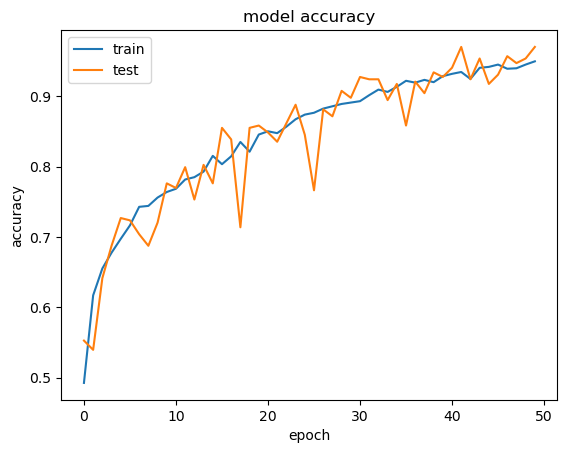

In [40]:
plt.plot(history_callback.history['accuracy'])
plt.plot(history_callback.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.close()

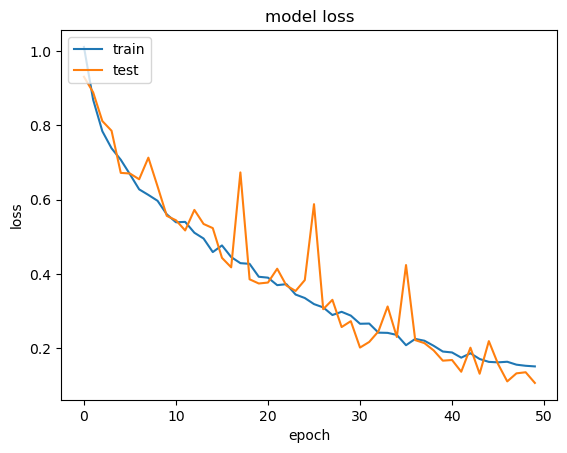

In [41]:
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.close()

In [44]:
from tensorflow.keras.preprocessing import image

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(300, 300))
    img = (np.asarray(img))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    return img_tensor

predImage = load_image('data_after_preprocessing/train/healthy-leaves/IMG_20220910_180119.JPG')
# predImage
pred = model.predict(predImage)
classes_pred=np.argmax(pred,axis=1)
classes_pred

# label [0,1,2] = ['healthy-leaves', 'liriomyza-leafspot','septoria-leafspot']

1/1 [==============================] - 0s 43ms/step


array([0])

In [45]:
load_model('data/model.h5')

### Load Model and Prediction Images

In [46]:
def loadModel(path):
    model_loaded = load_model(path)
    print(model_loaded)
    rmsprop = optimizers.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    model_loaded.compile(loss='categorical_crossentropy',
                optimizer=rmsprop,
                metrics=['accuracy'])
    model_loaded.summary()
    print('Load Model Successfull')

    return model_loaded

In [47]:
modelPredict = loadModel('data/model.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 35, 35, 32)      

In [48]:
imgPreprocessing = read_img('tms-data/train/septoria-leafspot/BK1.JPG')
imgPreprocessing = scale_img(imgPreprocessing)
imgPreprocessing = threshold(imgPreprocessing)
rgbImg = cv2.cvtColor(imgPreprocessing, cv2.COLOR_BGR2RGB)
cv2.imwrite('static/tempData/'+'BK1.JPG', rgbImg)

predImage = load_image('static/tempData/BK1.JPG')
pred = modelPredict.predict(predImage)
classes_pred=np.argmax(pred,axis=1)
classes_pred

1/1 [==============================] - 0s 80ms/step


2022-09-26 16:17:09.256030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([2])

### Confussion Matrix

In [49]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, 305 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['healthy-leaves', 'liriomyza-leafspot','septoria-leafspot']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/var/folders/vc/7c5ckn2x2yx926cf7_0bks700000gn/T/ipykernel_88318/1539494762.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, 305 // batch_size+1)
2022-09-26 16:17:34.802236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Confusion Matrix
[[ 96   1   3]
 [  3  97   0]
 [  1   2 102]]
Classification Report
                    precision    recall  f1-score   support

    healthy-leaves       0.96      0.96      0.96       100
liriomyza-leafspot       0.97      0.97      0.97       100
 septoria-leafspot       0.97      0.97      0.97       105

          accuracy                           0.97       305
         macro avg       0.97      0.97      0.97       305
      weighted avg       0.97      0.97      0.97       305



In [50]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('static/assets/confusion_matrix.png')

Normalized confusion matrix


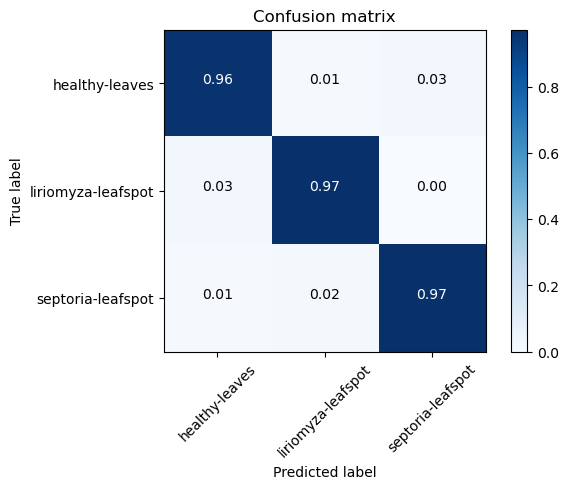

In [51]:
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm,target_names,normalize=True)